# <h1><center>Causal Learning</center></h1>

In [7]:
#importing essential modules
import sys
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from causalnex.discretiser import Discretiser
from causalnex.structure import DAGRegressor
from causalnex.inference import InferenceEngine
from causalnex.network import BayesianNetwork
from causalnex.network.sklearn import BayesianNetworkClassifier
from causalnex.structure.notears import from_pandas
from causalnex.structure.notears import from_pandas, from_pandas_lasso
from causalnex.discretiser.discretiser_strategy import ( DecisionTreeSupervisedDiscretiserMethod )


In [4]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score

In [5]:
sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)

In [8]:
#importing local modules
sys.path.append(os.path.abspath(os.path.join('../scripts')))
import visualization as vz
from pre_process import Process
from overview import Overview

In [10]:
#creating processing object
process = Process()

## Reading Data 

In [16]:
df = pd.read_csv("../data/data_cleaner.csv")
df.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.00,0.12,0.23,0.28,0.15,0.24,0.08,0.85,0.91,5.98,86.20,0.01,0.05,0.05,0.02,0.03,0.01,25.38,17.33,184.60,1937.05,0.16,0.63,0.71,0.27,0.42,0.12
1,842517,M,20.57,17.77,132.90,1326.00,0.08,0.08,0.09,0.07,0.18,0.06,0.54,0.73,3.40,74.08,0.01,0.01,0.02,0.01,0.01,0.00,24.99,23.41,158.80,1937.05,0.12,0.19,0.24,0.19,0.28,0.09
2,84300903,M,19.69,21.25,130.00,1203.00,0.11,0.16,0.20,0.13,0.21,0.06,0.75,0.79,4.58,86.20,0.01,0.04,0.04,0.02,0.02,0.00,23.57,25.53,152.50,1709.00,0.14,0.42,0.45,0.24,0.36,0.09
3,84348301,M,11.42,20.38,77.58,386.10,0.13,0.23,0.24,0.11,0.25,0.08,0.50,1.16,3.44,27.23,0.01,0.06,0.06,0.02,0.04,0.01,14.91,26.50,98.87,567.70,0.19,0.63,0.69,0.26,0.42,0.12
4,84358402,M,20.29,14.34,135.10,1297.00,0.10,0.13,0.20,0.10,0.18,0.06,0.76,0.78,5.44,86.20,0.01,0.02,0.06,0.02,0.02,0.01,22.54,16.67,152.20,1575.00,0.14,0.20,0.40,0.16,0.24,0.08


In [37]:
feat = ['diagnosis', 'perimeter_worst', 'area_worst', 'radius_worst', 'concave points_worst', 'concave points_mean', 'perimeter_mean', 'area_mean', 'radius_mean', 'area_se', 'concavity_mean', 'concavity_worst', 'perimeter_se', 'radius_se', 'compactness_worst', 'compactness_mean', 'texture_worst', 'concave points_se', 'smoothness_worst', 'texture_mean', 'symmetry_worst', 'concavity_se', 'smoothness_mean', 'symmetry_mean', 'compactness_se', 'fractal_dimension_worst', 'fractal_dimension_se', 'texture_se', 'fractal_dimension_mean', 'symmetry_se', 'smoothness_se']

In [39]:
#encode diagnosis 1 for malignant and 0 for benign
x = df[feat[:29]]
x['diagnosis'] = x['diagnosis'].apply(lambda x: 1 if x == "M" else 0)
x.head(5)

,diagnosis,perimeter_worst,area_worst,radius_worst,concave points_worst,concave points_mean,perimeter_mean,area_mean,radius_mean,area_se,concavity_mean,concavity_worst,perimeter_se,radius_se,compactness_worst,compactness_mean,texture_worst,concave points_se,smoothness_worst,texture_mean,symmetry_worst,concavity_se,smoothness_mean,symmetry_mean,compactness_se,fractal_dimension_worst,fractal_dimension_se,texture_se,fractal_dimension_mean
0,1,184.60,1937.05,25.38,0.27,0.15,122.80,1001.00,17.99,86.20,0.28,0.71,5.98,0.85,0.63,0.23,17.33,0.02,0.16,10.38,0.42,0.05,0.12,0.24,0.05,0.12,0.01,0.91,0.08
1,1,158.80,1937.05,24.99,0.19,0.07,132.90,1326.00,20.57,74.08,0.09,0.24,3.40,0.54,0.19,0.08,23.41,0.01,0.12,17.77,0.28,0.02,0.08,0.18,0.01,0.09,0.00,0.73,0.06
2,1,152.50,1709.00,23.57,0.24,0.13,130.00,1203.00,19.69,86.20,0.20,0.45,4.58,0.75,0.42,0.16,25.53,0.02,0.14,21.25,0.36,0.04,0.11,0.21,0.04,0.09,0.00,0.79,0.06
3,1,98.87,567.70,14.91,0.26,0.11,77.58,386.10,11.42,27.23,0.24,0.69,3.44,0.50,0.63,0.23,26.50,0.02,0.19,20.38,0.42,0.06,0.13,0.25,0.06,0.12,0.01,1.16,0.08
4,1,152.20,1575.00,22.54,0.16,0.10,135.10,1297.00,20.29,86.20,0.20,0.40,5.44,0.76,0.20,0.13,16.67,0.02,0.14,14.34,0.24,0.06,0.10,0.18,0.02,0.08,0.01,0.78,0.06


In [41]:
features = x.iloc[:, 1:]
features

,perimeter_worst,area_worst,radius_worst,concave points_worst,concave points_mean,perimeter_mean,area_mean,radius_mean,area_se,concavity_mean,concavity_worst,perimeter_se,radius_se,compactness_worst,compactness_mean,texture_worst,concave points_se,smoothness_worst,texture_mean,symmetry_worst,concavity_se,smoothness_mean,symmetry_mean,compactness_se,fractal_dimension_worst,fractal_dimension_se,texture_se,fractal_dimension_mean
0,184.60,1937.05,25.38,0.27,0.15,122.80,1001.00,17.99,86.20,0.28,0.71,5.98,0.85,0.63,0.23,17.33,0.02,0.16,10.38,0.42,0.05,0.12,0.24,0.05,0.12,0.01,0.91,0.08
1,158.80,1937.05,24.99,0.19,0.07,132.90,1326.00,20.57,74.08,0.09,0.24,3.40,0.54,0.19,0.08,23.41,0.01,0.12,17.77,0.28,0.02,0.08,0.18,0.01,0.09,0.00,0.73,0.06
2,152.50,1709.00,23.57,0.24,0.13,130.00,1203.00,19.69,86.20,0.20,0.45,4.58,0.75,0.42,0.16,25.53,0.02,0.14,21.25,0.36,0.04,0.11,0.21,0.04,0.09,0.00,0.79,0.06
3,98.87,567.70,14.91,0.26,0.11,77.58,386.10,11.42,27.23,0.24,0.69,3.44,0.50,0.63,0.23,26.50,0.02,0.19,20.38,0.42,0.06,0.13,0.25,0.06,0.12,0.01,1.16,0.08
4,152.20,1575.00,22.54,0.16,0.10,135.10,1297.00,20.29,86.20,0.20,0.40,5.44,0.76,0.20,0.13,16.67,0.02,0.14,14.34,0.24,0.06,0.10,0.18,0.02,0.08,0.01,0.78,0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,166.10,1937.05,25.45,0.22,0.14,142.00,1326.30,21.56,86.20,0.24,0.41,5.98,0.85,0.21,0.12,26.40,0.02,0.14,22.39,0.21,0.05,0.11,0.17,0.03,0.07,0.00,1.26,0.06
565,155.00,1731.00,23.69,0.16,0.10,131.20,1261.00,20.13,86.20,0.14,0.32,5.20,0.77,0.19,0.10,38.25,0.02,0.12,28.25,0.26,0.04,0.10,0.18,0.02,0.07,0.00,2.43,0.06
566,126.70,1124.00,18.98,0.14,0.05,108.30,858.10,16.60,48.55,0.09,0.34,3.42,0.46,0.31,0.10,34.12,0.02,0.11,28.08,0.22,0.05,0.08,0.16,0.04,0.08,0.00,1.07,0.06
567,184.60,1821.00,25.74,0.27,0.15,140.10,1265.00,20.60,86.20,0.28,0.79,5.77,0.73,0.63,0.23,39.42,0.02,0.17,29.33,0.41,0.07,0.12,0.24,0.06,0.12,0.01,1.59,0.07


In [42]:
normal_data = process.scale_and_normalize(features, features.columns.to_list())
normal_data.insert(loc=0, column='diagnosis', value=x['diagnosis'])
normal_data.head()

,diagnosis,perimeter_worst,area_worst,radius_worst,concave points_worst,concave points_mean,perimeter_mean,area_mean,radius_mean,area_se,concavity_mean,concavity_worst,perimeter_se,radius_se,compactness_worst,compactness_mean,texture_worst,concave points_se,smoothness_worst,texture_mean,symmetry_worst,concavity_se,smoothness_mean,symmetry_mean,compactness_se,fractal_dimension_worst,fractal_dimension_se,texture_se,fractal_dimension_mean
0,1,0.22,0.22,0.20,0.20,0.21,0.17,0.16,0.16,0.22,0.22,0.20,0.22,0.22,0.22,0.22,0.04,0.14,0.17,0.01,0.22,0.15,0.18,0.22,0.18,0.21,0.17,0.06,0.22
1,1,0.26,0.33,0.29,0.21,0.15,0.28,0.33,0.30,0.28,0.10,0.10,0.17,0.19,0.09,0.09,0.12,0.18,0.14,0.13,0.15,0.07,0.12,0.17,0.06,0.17,0.12,0.06,0.08
2,1,0.20,0.23,0.21,0.22,0.22,0.22,0.24,0.23,0.27,0.19,0.15,0.20,0.23,0.18,0.18,0.12,0.22,0.16,0.15,0.21,0.12,0.18,0.19,0.17,0.13,0.14,0.06,0.09
3,1,0.09,0.06,0.09,0.22,0.17,0.08,0.05,0.08,0.07,0.22,0.22,0.13,0.13,0.25,0.25,0.12,0.19,0.25,0.13,0.25,0.17,0.25,0.25,0.25,0.25,0.25,0.10,0.25
4,1,0.22,0.23,0.22,0.16,0.20,0.26,0.29,0.26,0.29,0.21,0.15,0.26,0.26,0.09,0.16,0.04,0.22,0.16,0.07,0.09,0.20,0.16,0.15,0.11,0.09,0.17,0.06,0.09


In [43]:
%%time
sm = from_pandas(normal_data.iloc[:, :9], tabu_parent_nodes=['diagnosis'],)

CPU times: user 1min 6s, sys: 1min 26s, total: 2min 32s
Wall time: 45.5 s


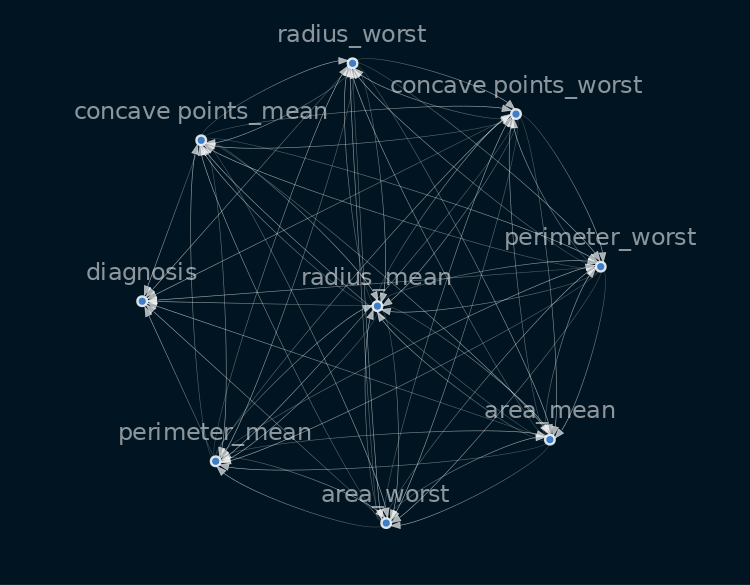

In [48]:
vz.vis_sm(sm)

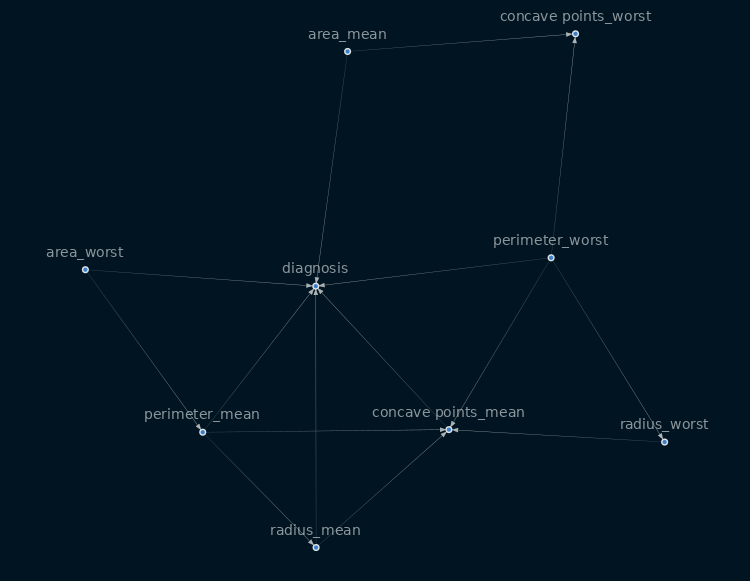

In [49]:
sm.remove_edges_below_threshold(0.8)
vz.vis_sm(sm)

In [50]:
#Stablity of causal graph
x_selected = normal_data.iloc[:, :10]

In [53]:
#50%
portion = int(x_selected.shape[0] *.5)
x_portion = x_selected.head(portion)

CPU times: user 1min 9s, sys: 1min 38s, total: 2min 48s
Wall time: 52.9 s


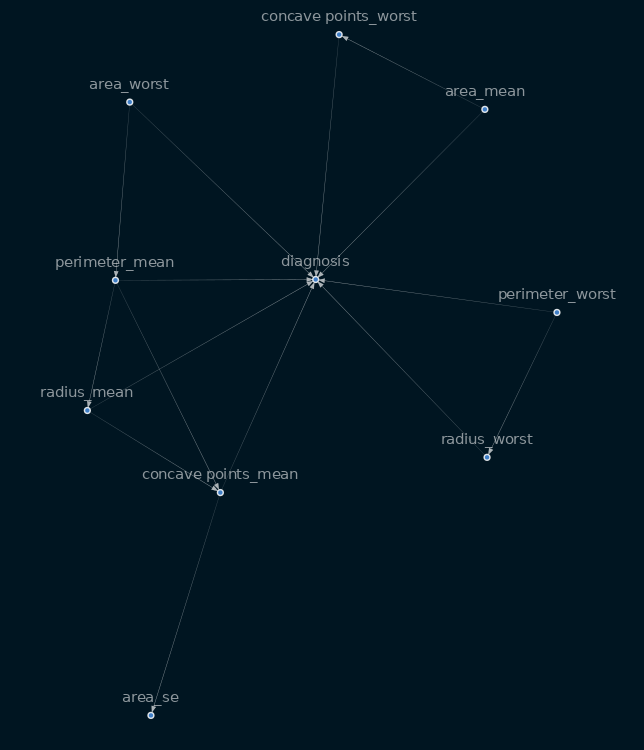

In [55]:
%%time
sm1 = from_pandas(x_portion, tabu_parent_nodes=['diagnosis'],)
sm1.remove_edges_below_threshold(0.8)
sm1 = sm1.get_largest_subgraph()
vz.vis_sm(sm1)

In [56]:
#75%
portion = int(x_selected.shape[0]*.75)
x_portion = x_selected.head(portion)

CPU times: user 1min 18s, sys: 1min 50s, total: 3min 9s
Wall time: 58.5 s


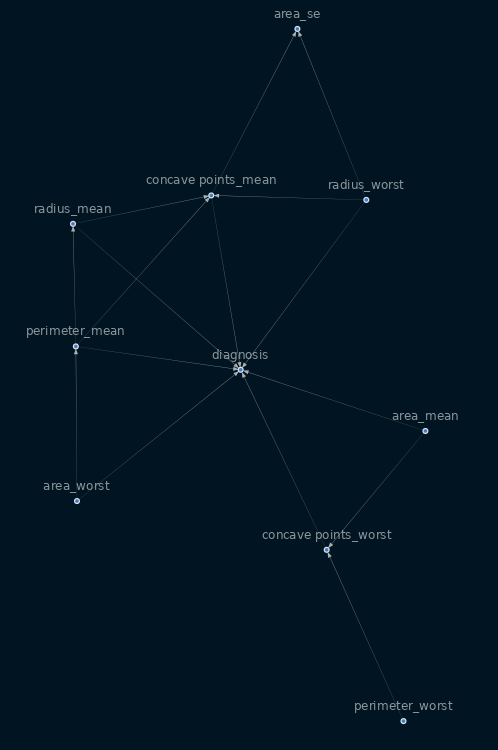

In [57]:
%%time
sm2 = from_pandas(x_portion, tabu_parent_nodes=['diagnosis'],)
sm2.remove_edges_below_threshold(0.8)
sm2 = sm2.get_largest_subgraph()
vz.vis_sm(sm2)

In [58]:
def jaccard_similarity(g, h):
    i = set(g).intersection(h)
    return round(len(i) / (len(g) + len(h) - len(i)), 3)

In [59]:
jaccard_similarity(sm1.edges, sm2.edges)

0.722

In [63]:
portion = int(x_selected.shape[0] * .9)
x_portion = x_selected.head(portion)

CPU times: user 1min 11s, sys: 1min 34s, total: 2min 45s
Wall time: 48.7 s


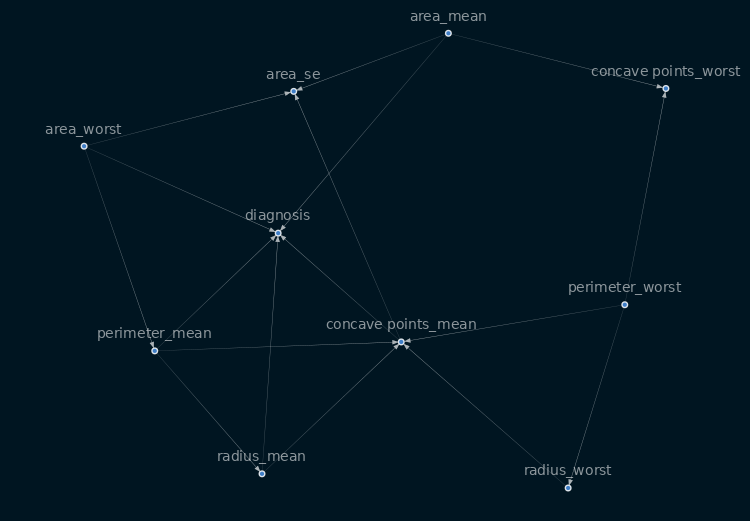

In [65]:
%%time
sm5 = from_pandas(x_portion, tabu_parent_nodes=['diagnosis'],)
sm5.remove_edges_below_threshold(0.8)
sm5 = sm5.get_largest_subgraph()
vz.vis_sm(sm5)

CPU times: user 1min 7s, sys: 1min 29s, total: 2min 36s
Wall time: 46.1 s


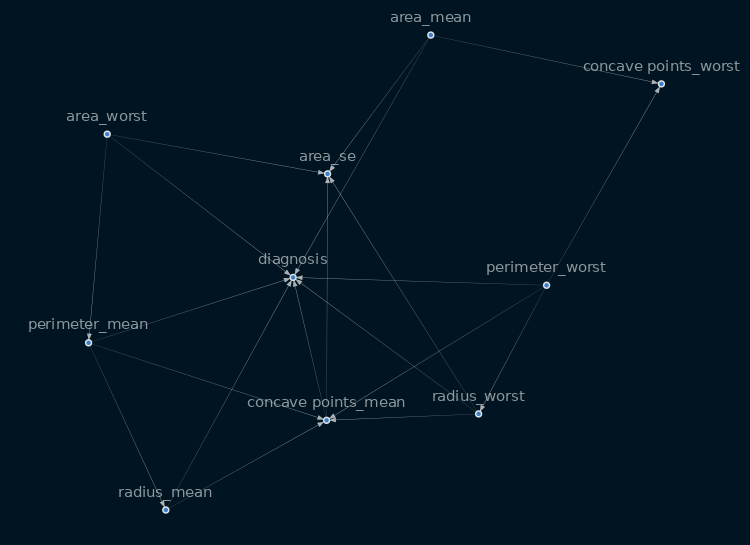

In [67]:
#100%
%%time
sm = from_pandas(x_selected, tabu_parent_nodes=['diagnosis'],)
sm.remove_edges_below_threshold(0.8)
sm = sm.get_largest_subgraph()
vz.vis_sm(sm)

In [68]:
jaccard_similarity(sm.edges, sm5.edges)

0.85